# Epsilon Selection

In this script, we will be testing several different epsilons as a kmapper parameter to determine how many states persist when as this value changes. We will first run the kmapper algorithm on the whole interpolated and cleaned LTRM water quality data set. We will then use code written by Killian to determine the density of each node, find local maximum, and determine local maxima states. We will count how many states are in each scomplex with the different choices of epsilon. Since the states, as of now, do not hold qualitative meaning, we will only be comparing state persistence as a count of how many there are and generally where they exist in the simplicial complex. Also note that the state analysis is run only on the largest shape in the simplicial complex.

## Import libraries

In [3]:
import kmapper as km
from kmapper.plotlyviz import *
import pandas as pd

import sklearn
#from sklearn import ensemble
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
# from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# scipy for interpolation
# import scipy 
# from scipy.interpolate import *
import hdbscan
import pickle as pk
import json as js
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

# Plotly and Dash
import plotly.graph_objs as go
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
from ipywidgets import (HBox, VBox)
import dash_html_components as html
import dash_core_components as dcc
import dash
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
warnings.filterwarnings("ignore")

## Read data

In [4]:
water20 = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")
#water20 = water20[["SHEETBAR", "DATE", "LATITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
#"TN","TP","TEMP", "DO", "TURB", "VEL", "SS", "WDP", "CHLcal",  "SECCHI", "YEAR", "SEASON"]]

## Robust Scaling

In [5]:
water_df = water20[["WDP", "SECCHI", "TEMP", "DO", "TURB",
             "VEL", "TP", "TN", "SS", "CHLcal", 
             "YEAR", "SEASON", "FLDNUM", "STRATUM"]]

ct = ColumnTransformer([
        ('somename', RobustScaler(), ["WDP", "SECCHI", "TEMP", "DO", "TURB",
                                        "VEL", "TP", "TN", "SS", "CHLcal"])
    ], remainder='passthrough')

water_df = pd.DataFrame(ct.fit_transform(water_df), columns = ["WDP", "SECCHI", "TEMP", "DO", "TURB",
                                                 "VEL", "TP", "TN", "SS", "CHLcal", 
                                                 "YEAR", "SEASON", "FLDNUM", "STRATUM"])

water_df = pd.DataFrame(water_df, columns = ["WDP", "SECCHI", "TEMP", "DO", "TURB",
                             "VEL", "TP", "TN", "SS", "CHLcal"])

## Kmapper function

In [6]:
def mapper_func(df, DBSCAN_EPSILON = 20, DBSCAN_MIN_SAMPLES = 20, N_CUBES = [10, 10], PERC_OVERLAP = [.45, .45]):
    
    X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]
    continuous_variables =  ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

    var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
    #projected_vars = continuous_variables
    projected_var_indices = [var_to_index[var] for var in continuous_variables]

    # defining clustering and kmapper parameters
    # create instance of clustering alg
    cluster_alg = sklearn.cluster.DBSCAN(eps = DBSCAN_EPSILON, min_samples = DBSCAN_MIN_SAMPLES, metric = 'euclidean')

    # Instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose = 0)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components = 2)
    lens = pca.fit_transform(X)

    #pca.fit_transform(X)
    principle_component = max(abs(pca.components_[0].min()), abs(pca.components_[0].max()))
    max_index = 0

    for i in range(len(pca.components_[0])):
        if abs(pca.components_[0][i]) == principle_component:
            max_index = i

    #print("Primary variable: ", continuous_variables[max_index])
    #print("Corresponding component: ", pca.components_[0][max_index])
    #print('Explained Variance: ', pca.explained_variance_ratio_)
    
    #lens = np.array(X[continuous_variables[max_index]])
    #lens = np.array(X[['PredictedTN', 'PredictedSS']])
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X, cover = km.Cover(n_cubes = N_CUBES, perc_overlap = PERC_OVERLAP), 
                                                    clusterer = cluster_alg, remove_duplicate_nodes = True)  

    return scomplex, X

## Parameters

Some of the parameters for the clustering algorithm and the kmapper have already been selected. For kmapper, we will be using a cube size of 125 and a 40% overlap. The cube size is much larger than previously because robust scaling has made the point cluster much more dense. In order to gain high resolution of the data, we needed to divide each bin up by a larger number of cubes. A 40% overlap was selected because it provides a more continuous view of the data. Though we it contributes to more redundancy of nodes, we are okay with this because it adds resolution to the data. As for the DBSCAN parameters, we know that we want minsamples to be 10 because it ensures that each cluster has enough points while ignoring some clusteres that do not have enough data to be considered significant. All that is left is to determine the epsilon parameter. These parameters were also selected so that that largest node represents no more than 10% of the original data set and so that only about 5% of the data is lost due to cluster noise.

The epsilon parameter is important because it indirectly determines how much noise we will allow in our simplicial complex as well as determining how many nodes will be in the resulting simplicial complex. A smaller epsilon makes it less likely that a cluster will achieve the minimum number of samples, thus resulting in a larger amount of data lost as "noise". A larger epsilon will group more data together than may be necessary and will as a result, lose a bit of resolution and detail of the data set. 

We will be using the number of persistent states as a measure of how good our epsilon because it will indirectly decide how much noise we are okay with losing with our parameter selection. The LTRM data is very noisy meaning that there is a lot of variable in many of the different variables. Some of this noise may be exactly that while other noise may indicate a rare but important state. With that said, we may no want to lose some of the data's noise as clustering noise. Looking at state persistence will help us to choose this parameter without directly choosing what we will be calling noise.

In [20]:
scomplex_dict = {}
df_dict = {}

epsilon_list = [.5, .6, .7, .8, .9, 1, 1.1]

for i in epsilon_list:
    title = 'Epsilon_' + str(i)
    scomplex, X = mapper_func(water_df, i, 10, [125, 125], [.4, .4])
    scomplex_dict[title] = scomplex
    df_dict[title] = X

# Get the number of maxima


In [7]:
variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP","TN", "SS", "CHLcal"]

## Calculating Density for Nodes in the Largest Structure - Killian

In [8]:
from sklearn.neighbors import NearestNeighbors
import queue

### Functions

In [9]:
def getSubdf(scomplex, shape, df):
    """
    Returns the part of the data frame from the particular shape in the simplicial complex.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex)
    df: the entire data frame
    
    Description:
    1. Get all the nodes from the particular simplicial complex. 
    2. Generate the indices we care about from the particular shape. To do this, we read each node and append it's 
    indices to a list. Then, we convert the list to a set and then back to a list to eliminate duplicates.
    3. Return the dataframe with only those indices.
    """
    
    nodes = scomplex.get('nodes')
    indices = []
    npShape = np.array(shape).flatten()
    for node in npShape:
        indices.append(nodes.get(node))
    indices = list(set([item for sublist in indices for item in sublist]))
    subdf = df.loc[indices]
    return subdf

def adjacent(v, scomplex):
    """
    Determines the nodes adjacent to a given vertex
    
    params:
    v: vertex
    scomlex: the entire simplicial complex
    
    Description:
    Determines the nodes that are adjacent to a given vertex.
    """
    
    simplices = scomplex.get('simplices')
    edges = [item for item in simplices if len(item) == 2]
    result = []
    for edge in edges:
        if v in edge:
            for item in edge:
                if item != v:
                    result.append(item)
    return result

def bfs(node, scomplex):
    """
    Conducts a breadth first search to obtain the entire shape from a given node
    params:
    node: the start node
    scomplex: the entire simplicial complex
    
    Description:
    Preforms a breadth first search to obtain the entire shape for a given start node.
    """
    Q = queue.Queue()
    result = []
    result.append(node)
    Q.put(node)
    while not Q.empty():
        v = Q.get()
        adjacentEdges = adjacent(v, scomplex)
        for edge in adjacentEdges:
            if edge not in result:
                result.append(edge)
                Q.put(edge)
    return result

def getShapes(scomplex):
    """
    Gets all of the shapes from a given simplicial complex.
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Obtain all the nodes for the entire complex
    2. For each node, preform a breadth first search to obtain everything in that particular shape. 
    If this entire shape has not already been discovered, add it to the set of results. 
    The result item is a set as the order of the shapes does not matter. The resulting shape is a frozenset
    which means items cannot be added or removed once created, and is needed to allow the set object to have other sets within it.
    3. Convert each shape to a list and the result to a list for easier navigation outside of the function.
    4. Return the result
    
    """
    
    nodes = list(scomplex.get('nodes').keys())
    result = set()
    for node in nodes: # currently does more computations than necessary due to going through every node without considering it is already in a shape
        bfsResult = frozenset(bfs(node, scomplex))
        result.add(bfsResult)
    result = [list(x) for x in result]
    # Sort the list depending on what is decided: nodes or indices. Currently doing it by number of nodes
    result.sort(key = len, reverse = True)
    
    
    
    return result

def condenseShape(shape, scomplex):
    """
    
    params:
    shape: a shape of two nodes. must be 2
    scomplex: the entire simplicial complex
    
    description:
    gets the two nodes a and b
    gets the indices for a and b (what is inside the nodes)
    if a \subseteq b, return b
    elif b \subseteq a, return a 
    else return shape 
    
    """
    nodes = scomplex.get('nodes')
    a = shape[0]
    b = shape[1]
    aIndices = set(nodes.get(a))
    bIndices = set(nodes.get(b))
    
    if aIndices.issubset(bIndices):
        return b
    elif bIndices.issubset(aIndices):
        return a
    else:
        return shape

def clean_getShapes(scomplex):
    """
    Condenses 1-simplices down to 0-simplices when each node 
    is a subset of the other 
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Get all the shapes from the original getShapes function
    2. For shapes that of length 2, if one is a subset of the other, return the larger of the two
        Otherwise, do nothing
    3. return the clean Shapes list 
    
    """
    shapes = getShapes(scomplex)
    cleanShapes = []
    for shape in shapes:
        if len(shape) == 2:
            shape = condenseShape(shape, scomplex)
            cleanShapes.append([shape])
        else:
            cleanShapes.append(shape)
    return cleanShapes

def k_nearest_neighbors(df, neigh, point, k):
    return neigh.kneighbors([list(df.loc[point])], k)[0].flatten()
    
def calculate_density(scomplex, node, df, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    knn = 0
    n = len(scomplex['nodes'][node])
    for point in scomplex['nodes'][node]:
        distances = k_nearest_neighbors(df, neigh, point, k)
        knn += (sum(distances) / k)
    density = knn / (n*n)
    return (1.0 / density)

### Get the density for each node in each scomplex

In [21]:
allComplices = list(scomplex_dict.keys())
df = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")
df = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]

for key in allComplices: # remove the indices here to get all the strata for all the time periods
    print("Current Simplical Complex: ", key)
    scomplex = scomplex_dict.get(key)
    scomplex['density'] = {}
    largestShape = clean_getShapes(scomplex)[0]
    #print("Largest shape is: ", largestShape, "\n")
    largestShape_df = getSubdf(scomplex, largestShape, df_dict.get(key))
    k = int((df_dict.get(key).shape[0] / 10) + 1)
    for node_name in largestShape:
        #scomplex['density'][node_name] = calculate_density(scomplex, node_name, largestShape_df, k)
        scomplex['density'][node_name] = calculate_density(scomplex, node_name, df_dict.get(key), k)

Current Simplical Complex:  Epsilon_0.5
Current Simplical Complex:  Epsilon_0.6
Current Simplical Complex:  Epsilon_0.7
Current Simplical Complex:  Epsilon_0.8
Current Simplical Complex:  Epsilon_0.9
Current Simplical Complex:  Epsilon_1
Current Simplical Complex:  Epsilon_1.1


## Get the maxima for each scomplex and create a directed graph





### Functions

In [10]:
import networkx as nx

In [11]:
def generate_graph(scomplex, shape):
    dg = generate_nodes(scomplex, shape)
    dg = generate_edges(scomplex, shape, dg)
    return dg

def generate_nodes(scomplex, shape):
    dg = nx.DiGraph()
    dg.add_nodes_from(shape)
    return dg

def generate_edges(scomplex, shape, dg):
    for node in shape:
        if node in scomplex['links']:
            for adjacent_node in scomplex['links'][node]:
                if scomplex['density'][node] < scomplex['density'][adjacent_node]:
                    dg.add_edge(node, adjacent_node)
                else:
                    dg.add_edge(adjacent_node, node)
    return dg

def get_local_maxima(dg):
    maxima = []
    for node in list(dg.nodes):
        succ = dict(nx.bfs_successors(dg, source=node))
        if not succ[node]:
            maxima.append(node)
    return maxima

def draw_graph(scomplex, filepath, with_labels = False):
    colors = ['#00A08A', '#e80909', '#F2AD00', '#a6d96a', '#d9ef8b', '#d0e1f0', '#74a7d2',
             '#295981', '#17334a', '#a2a0f7', '#e68a0d', '#a68a52', '#50704a', '#458B74', '#817f85']
    colors_dict = {scomplex['maxima'][i] : colors[i] for i in range(len(scomplex['maxima']))}
    transition_color = '#ffffbf'
    color_map = []
    scomplex['states'] = {scomplex['maxima'][i] : [] for i in range(len(scomplex['maxima']))}
    
    fig = plt.figure(figsize = (12,12))
    ax = plt.subplot(111)

    title = filepath[:-4]
    ax.set_title(title, fontsize = 60)
    
    for node in scomplex['graph']:
        distDict = {scomplex['maxima'][i] : graph_distance(scomplex['graph'], node, scomplex['maxima'][i])
                    for i in range(len(scomplex['maxima']))}
        minDist = min(distDict.values())
        states = [maxima if distDict[maxima] == minDist else None for maxima in scomplex['maxima']]
        states = list(filter(None, states))
        
        for state in states:
            scomplex['states'][state].append(node)
        
        if len(states) > 1:
            color_map.append(transition_color)
        else:
            color_map.append(colors_dict[states[0]])

    
    nx.draw_kamada_kawai(scomplex['graph'], with_labels = with_labels, node_color = color_map)
    plt.tight_layout()
    plt.savefig(filepath, format = "PNG")
    plt.show()

def graph_distance(dg, source, target):
    if nx.has_path(dg, source, target):
        return len(nx.shortest_path(dg, source, target))
    return float('inf')

### Determine how many samples are in the largest structure

In [44]:
for key in allComplices:
    scomplex = scomplex_dict.get(key)
    largestShape = clean_getShapes(scomplex)[0]
    temp_df = getSubdf(scomplex, largestShape, water_df)
    print(temp_df.shape)

(46060, 10)
(58260, 10)
(64415, 10)
(67915, 10)
(70319, 10)
(71663, 10)
(72508, 10)


### Make the digraph for each largest object in the simplicial complex

In [24]:
for key in allComplices: # remove the indices here to get all the strata for all the time periods
    scomplex = scomplex_dict.get(key)
    print(key)
    largestShape = clean_getShapes(scomplex)[0]
    scomplex['graph'] = {}
    scomplex['graph'] = generate_graph(scomplex, largestShape)
    scomplex['maxima'] = get_local_maxima(scomplex['graph'])
    print(key + ": " + str(len(scomplex['maxima'])) )

Epsilon_0.5
Epsilon_0.5: 14
Epsilon_0.6
Epsilon_0.6: 11
Epsilon_0.7
Epsilon_0.7: 14
Epsilon_0.8
Epsilon_0.8: 9
Epsilon_0.9
Epsilon_0.9: 9
Epsilon_1
Epsilon_1: 7
Epsilon_1.1
Epsilon_1.1: 8


### Print out the colored digraphs for the largest shape in each simplicial complex

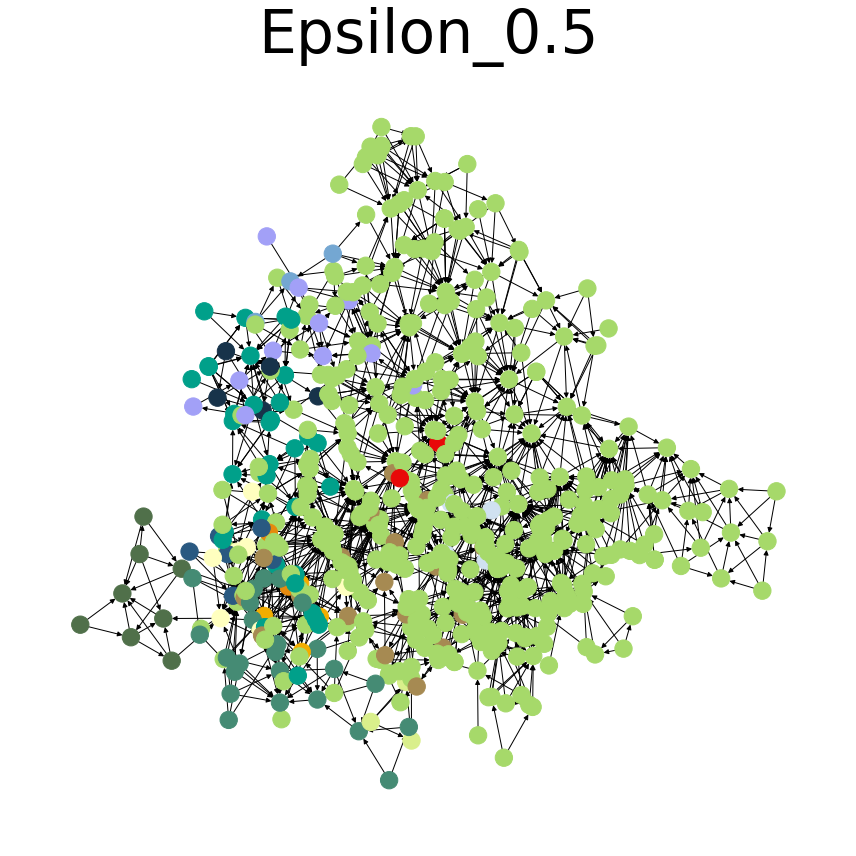

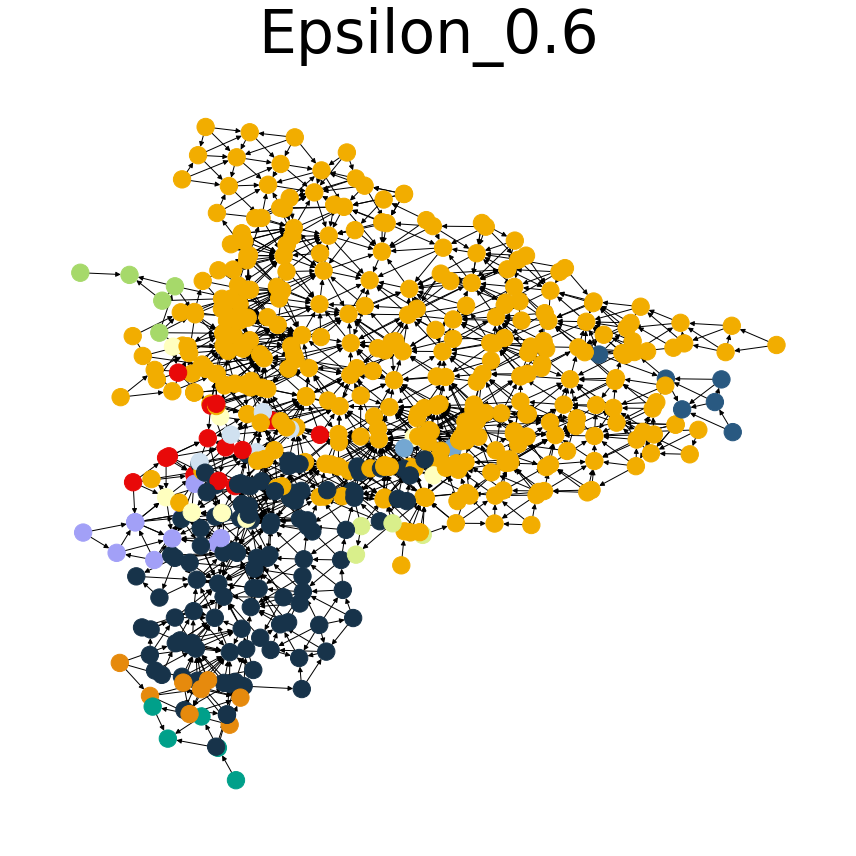

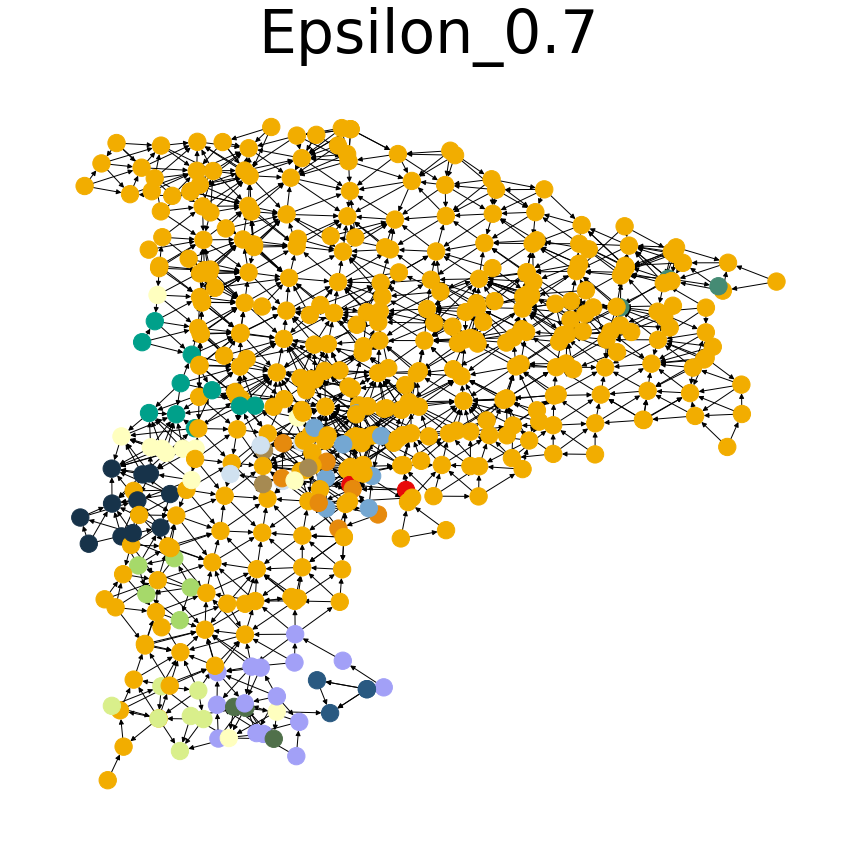

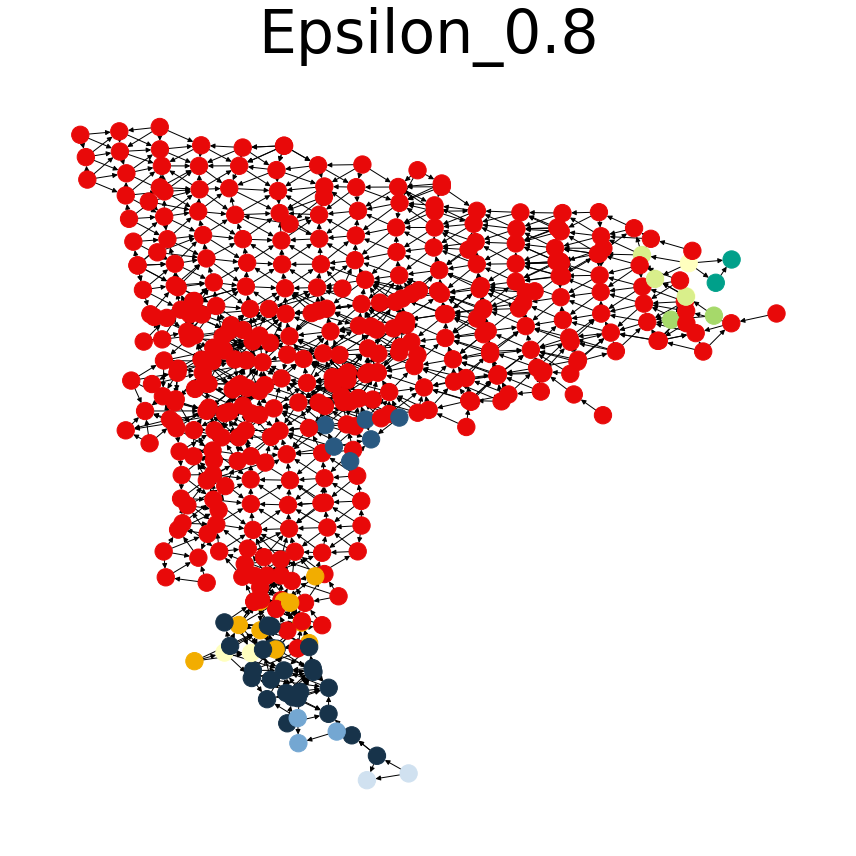

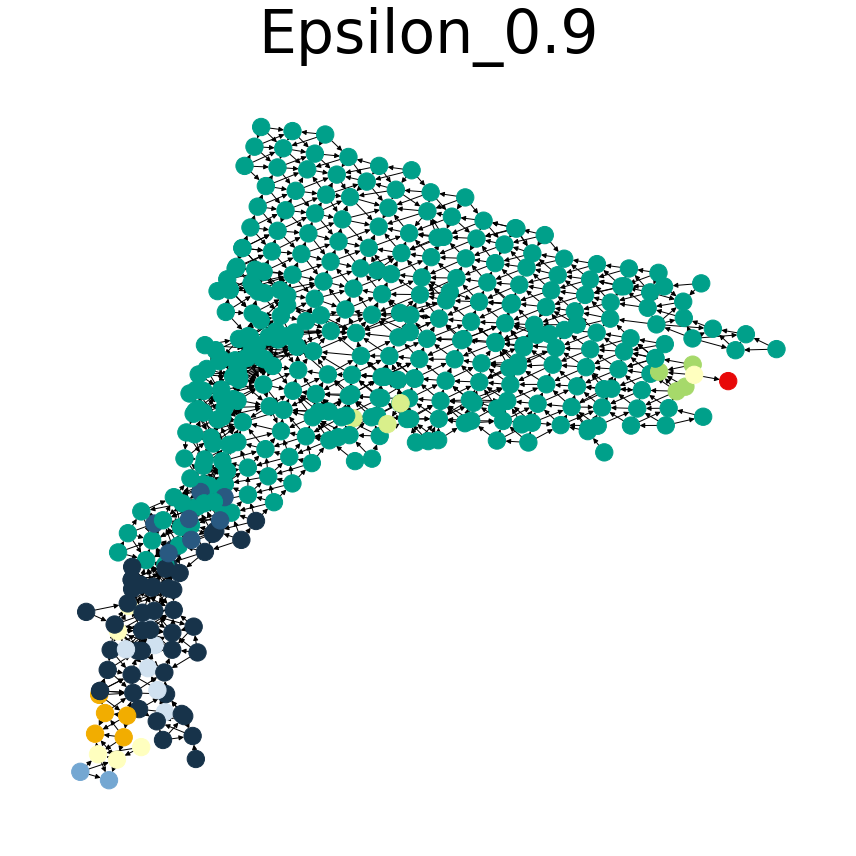

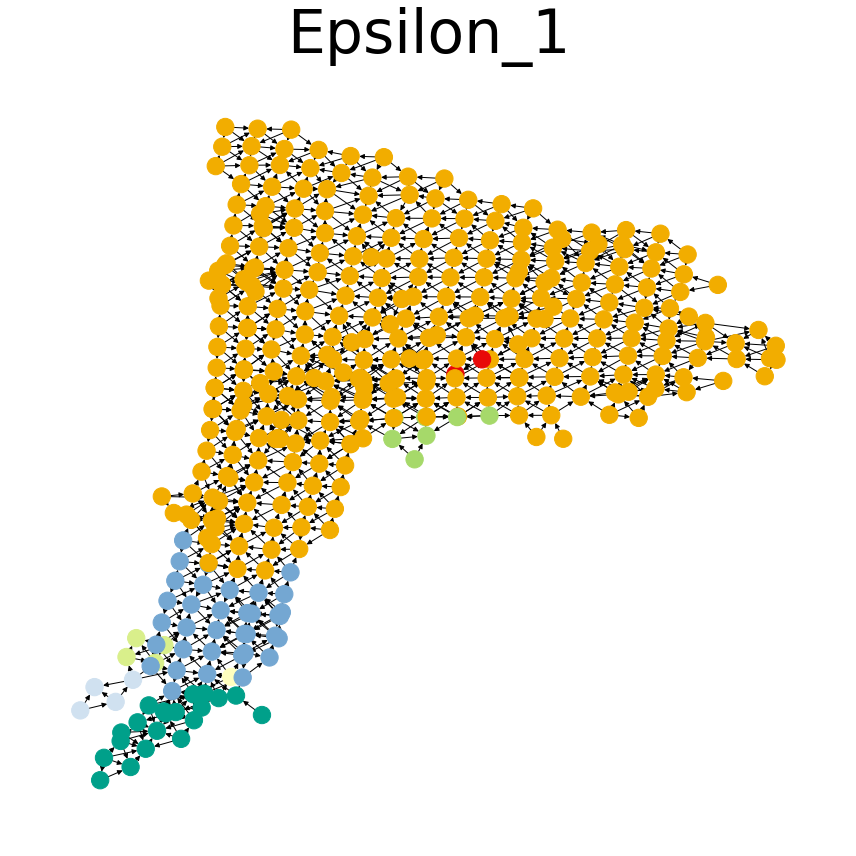

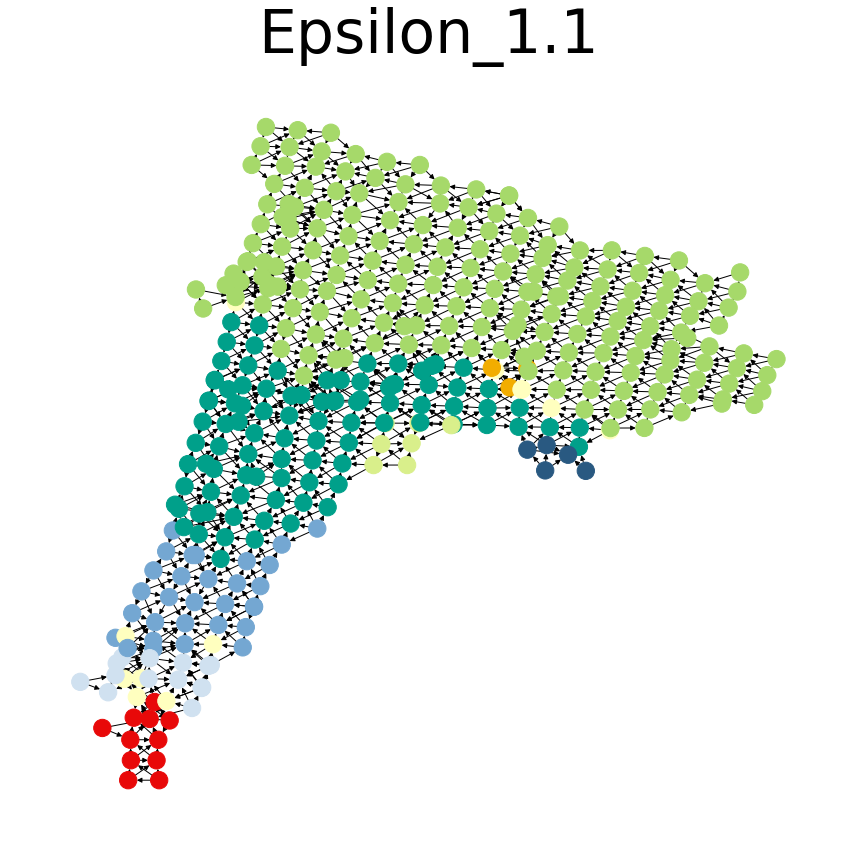

In [38]:
for key in allComplices:
    filepath = str(key) + ".png"
    draw_graph(scomplex_dict[key], filepath, with_labels = False)

In [46]:

pickle = pk.dump(scomplex_dict, open("Epsilon_testing.p", "wb"))

# Results: epilson = 1.0

One important factor used to decide which epsilon would be best was which epsilon perserved the most data in the largest shape. Notice that as the epsilon increases, so does the amount of data that is contained in the largest shape. We also looked at how many states were in each of the outputs with the different epsilons. The outputs for epsilon = .5, .6, and .7 all had a similar number of states, whereas the outputs for epsilon = .8, .9, 1, 1.1 were fairly similar in number. We decided that since the later epsilon values retained the most data, we would use one of them for our epsilon choice. We decided on 1 because its value can be easily interpreted and understood when we condsider that the data has been scaled with RobustScaling. While the output with epsilon = 1.1 had the largest state conveniently split into two different states, we decided that we would still use epsilon as 1 because the large state persisted through epsilon = .8, .9, and 1.0.

# Parameter selection from paper
source: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

After running this analysis, Killian found a guide for how to choose our DBSCAN parameters. The number of min-samples should be 2*dimensions. Using a nearest neighbors analysis, we can use the y-coordinate of the point of the greatest curvature to choose our epsilon. We plot the average distance of a point and its 'MIN_SAMPLES' (20) nearest neighbors. We sort by ascending order and then plot.

According to this article, our min_samples should be 20 and the epsilon should be 1.2. 

In [ ]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

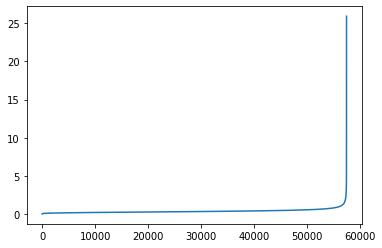

In [52]:
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.plot(distances)

# Check epsilon selection with different subsets of data - no longer needed

Iniitially we thought that the Gut microbiome paper was checking the persistence of states across mulitiple subsets of the data however, this was not the case. They were using multiple different sizes of subsets in order to see the distribution of 0% diarrhea and 100% diarrhea. It makes sense with our intuition that the smaller subsets of the data had a less even split of the two states. 

In [2]:
import random

In [13]:
scomplex25_dict = {}
dfs25_dict = {}

scomplex50_dict = {}
dfs50_dict = {}

scomplex75_dict = {}
dfs75_dict = {}

random.seed(47474)

In [16]:
# Change the subset_perc and respective dictionaries to make sure its matches
subset_perc = [.75]
for i in subset_perc: 
    for j in range(0, 10): # Will run 10 times
        TEMP_DATA = water_df.sample(n = int(i * len(water_df)))
        print("DATA SIZE: " + str(int(i * len(water_df))))
        title = str(int(i* 100)) + '% SUBSET ' + str(j + 1)+ ': Epsilon_' + str(1.2) + '_MinSamp_' + str(20)
        print(title)
        scomplex, X = mapper_func(TEMP_DATA, 1.2, 20, [125,125], [.4,.4])
        scomplex75_dict[title] = scomplex
        dfs75_dict[title] = X
        

DATA SIZE: 57501
75% SUBSET 1: Epsilon_1.2_MinSamp_20
DATA SIZE: 57501
75% SUBSET 2: Epsilon_1.2_MinSamp_20
DATA SIZE: 57501
75% SUBSET 3: Epsilon_1.2_MinSamp_20
DATA SIZE: 57501
75% SUBSET 4: Epsilon_1.2_MinSamp_20
DATA SIZE: 57501
75% SUBSET 5: Epsilon_1.2_MinSamp_20
DATA SIZE: 57501
75% SUBSET 6: Epsilon_1.2_MinSamp_20
DATA SIZE: 57501
75% SUBSET 7: Epsilon_1.2_MinSamp_20
DATA SIZE: 57501
75% SUBSET 8: Epsilon_1.2_MinSamp_20
DATA SIZE: 57501
75% SUBSET 9: Epsilon_1.2_MinSamp_20
DATA SIZE: 57501
75% SUBSET 10: Epsilon_1.2_MinSamp_20


## Densitites for each set of scomplices

### 25% subsets

In [18]:
allComplices = list(scomplex25_dict.keys())
df = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")
df = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]

for key in allComplices: # remove the indices here to get all the strata for all the time periods
    print("Current Simplical Complex: ", key)
    scomplex = scomplex25_dict.get(key)
    scomplex['density'] = {}
    largestShape = clean_getShapes(scomplex)[0]
    dfs25_dict[key].reset_index(drop = True, inplace = True)
    #print("Largest shape is: ", largestShape, "\n")
    largestShape_df = getSubdf(scomplex, largestShape, dfs25_dict.get(key))
    k = int((dfs25_dict.get(key).shape[0] / 10) + 1)
    for node_name in largestShape:
        #scomplex['density'][node_name] = calculate_density(scomplex, node_name, largestShape_df, k)
        scomplex['density'][node_name] = calculate_density(scomplex, node_name, dfs25_dict.get(key), k)

Current Simplical Complex:  25% SUBSET 1: Epsilon_1.2_MinSamp_20
Current Simplical Complex:  25% SUBSET 2: Epsilon_1.2_MinSamp_20
Current Simplical Complex:  25% SUBSET 3: Epsilon_1.2_MinSamp_20
Current Simplical Complex:  25% SUBSET 4: Epsilon_1.2_MinSamp_20
Current Simplical Complex:  25% SUBSET 5: Epsilon_1.2_MinSamp_20
Current Simplical Complex:  25% SUBSET 6: Epsilon_1.2_MinSamp_20
Current Simplical Complex:  25% SUBSET 7: Epsilon_1.2_MinSamp_20
Current Simplical Complex:  25% SUBSET 8: Epsilon_1.2_MinSamp_20
Current Simplical Complex:  25% SUBSET 9: Epsilon_1.2_MinSamp_20
Current Simplical Complex:  25% SUBSET 10: Epsilon_1.2_MinSamp_20


#### Get how much of the data is retained in the largest shape

In [ ]:
for key in allComplices:
    scomplex = scomplex25_dict.get(key)
    largestShape = clean_getShapes(scomplex)[0]
    temp_df = getSubdf(scomplex, largestShape, water_df)
    print(key + ": " + temp_df.shape)

#### Make the graph for each scomplex

In [19]:
print("Maxima counts for 25 percent subsets: ")
for key in allComplices: # remove the indices here to get all the strata for all the time periods
    scomplex = scomplex25_dict.get(key)
    #print(key)
    largestShape = clean_getShapes(scomplex)[0]
    scomplex['graph'] = {}
    scomplex['graph'] = generate_graph(scomplex, largestShape)
    scomplex['maxima'] = get_local_maxima(scomplex['graph'])
    print(key + ": " + str(len(scomplex['maxima'])) )

Maxima counts for 25 percent subsets: 
25% SUBSET 1: Epsilon_1.2_MinSamp_20: 3
25% SUBSET 2: Epsilon_1.2_MinSamp_20: 3
25% SUBSET 3: Epsilon_1.2_MinSamp_20: 4
25% SUBSET 4: Epsilon_1.2_MinSamp_20: 2
25% SUBSET 5: Epsilon_1.2_MinSamp_20: 3
25% SUBSET 6: Epsilon_1.2_MinSamp_20: 2
25% SUBSET 7: Epsilon_1.2_MinSamp_20: 4
25% SUBSET 8: Epsilon_1.2_MinSamp_20: 4
25% SUBSET 9: Epsilon_1.2_MinSamp_20: 3
25% SUBSET 10: Epsilon_1.2_MinSamp_20: 1


#### Save as a pickle file

In [20]:
pickle = pk.dump(scomplex25_dict, open("25_percent_subsets.p", "wb"))

### 50% subsets

#### Get the densities

In [21]:
allComplices = list(scomplex50_dict.keys())
df = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")
df = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]

for key in allComplices: # remove the indices here to get all the strata for all the time periods
    print("Current Simplical Complex: ", key)
    scomplex = scomplex50_dict.get(key)
    scomplex['density'] = {}
    largestShape = clean_getShapes(scomplex)[0]
    dfs50_dict[key].reset_index(drop = True, inplace = True)
    #print("Largest shape is: ", largestShape, "\n")
    largestShape_df = getSubdf(scomplex, largestShape, dfs50_dict.get(key))
    k = int((dfs50_dict.get(key).shape[0] / 10) + 1)
    for node_name in largestShape:
        #scomplex['density'][node_name] = calculate_density(scomplex, node_name, largestShape_df, k)
        scomplex['density'][node_name] = calculate_density(scomplex, node_name, dfs50_dict.get(key), k)

Current Simplical Complex:  50% SUBSET 1: Epsilon_1.2_MinSamp_20


KeyboardInterrupt: 

#### Determine how much of the data is retained in the largest shape

In [ ]:
for key in allComplices:
    scomplex = scomplex50_dict.get(key)
    largestShape = clean_getShapes(scomplex)[0]
    temp_df = getSubdf(scomplex, largestShape, water_df)
    print(key + ": " + temp_df.shape)

#### Make the digraph for each 

In [ ]:
for key in allComplices: # remove the indices here to get all the strata for all the time periods
    scomplex = scomplex50_dict.get(key)
    print(key)
    largestShape = clean_getShapes(scomplex)[0]
    scomplex['graph'] = {}
    scomplex['graph'] = generate_graph(scomplex, largestShape)
    scomplex['maxima'] = get_local_maxima(scomplex['graph'])
    print(key + ": " + str(len(scomplex['maxima'])) )

In [ ]:
for key in allComplices:
    filepath = str(key) + ".png"
    draw_graph(scomplex_dict[key], filepath, with_labels = False)

#### Save in a pickle file

In [ ]:
pickle = pk.dump(scomplex50_dict, open("50_percent_subsets.p", "wb"))

### 75% subset

#### Get the densities

In [ ]:
allComplices = list(scomplex75_dict.keys())
df = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")
df = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]

for key in allComplices: # remove the indices here to get all the strata for all the time periods
    print("Current Simplical Complex: ", key)
    scomplex = scomplex75_dict.get(key)
    scomplex['density'] = {}
    largestShape = clean_getShapes(scomplex)[0]
    dfs75_dict[key].reset_index(drop = True, inplace = True)
    #print("Largest shape is: ", largestShape, "\n")
    largestShape_df = getSubdf(scomplex, largestShape, dfs75_dict.get(key))
    k = int((dfs75_dict.get(key).shape[0] / 10) + 1)
    for node_name in largestShape:
        #scomplex['density'][node_name] = calculate_density(scomplex, node_name, largestShape_df, k)
        scomplex['density'][node_name] = calculate_density(scomplex, node_name, dfs75_dict.get(key), k)

#### Determine how much of the data is retained in the largest shape

In [ ]:
for key in allComplices:
    scomplex = scomplex25_dict.get(key)
    largestShape = clean_getShapes(scomplex)[0]
    temp_df = getSubdf(scomplex, largestShape, water_df)
    print(key + ": " + temp_df.shape)

In [ ]:
for key in allComplices: # remove the indices here to get all the strata for all the time periods
    scomplex = scomplex25_dict.get(key)
    print(key)
    largestShape = clean_getShapes(scomplex)[0]
    scomplex['graph'] = {}
    scomplex['graph'] = generate_graph(scomplex, largestShape)
    scomplex['maxima'] = get_local_maxima(scomplex['graph'])
    print(key + ": " + str(len(scomplex['maxima'])) )

In [ ]:
for key in allComplices:
    filepath = str(key) + ".png"
    draw_graph(scomplex_dict[key], filepath, with_labels = False)